In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from fastai import datasets
from pathlib import Path
import torch
import gzip
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
import random
import operator
import os 

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
#export
mpl.rcParams['image.cmap'] = 'gray'

def get_mnist_data():
    return get_data('http://deeplearning.net/data/mnist/mnist.pkl')
    
def get_data(URL):
    path = datasets.download_data(URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
    return x_train.float(), y_train, x_valid.float(), y_valid

def show_image(imgs):
    img = random.choice(imgs)
    if len(img.shape) == 1:
        size = int(img.shape[0] ** 0.5)
        shape = (size, size)
    else:
        shape = img.shape
    plt.imshow(img.view(shape))

In [4]:
#export
def test(a, b, cmp, cname=None):
    assert cmp(a, b), f"{cname or cmp.__name__}: \n{a}\n{b}"

def near(a, b): 
    return torch.allclose(a, b, rtol=1e-3, atol=1e-5)

def test_near(a, b): 
    test(a, b, near)

def test_near_zero(a,tol=1e-3):
    assert a.abs() < tol, f"Near zero: {a}"

In [5]:
#export
def matmul_naive(a, b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += a[i,k] * b[k,j]
    return c

def matmul_element(a, b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

def matmul_broadcast(a, b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        c[i] = (a[i].unsqueeze(-1) * b).sum(dim=0)
    return c

def matmul_einsum(a, b): 
    return torch.einsum('ik,kj->ij', a, b)

def matmul_torch(a, b):
    return a@b

In [6]:
#export
def normalize(x, m=None, s=None):
    m = m if m else x.mean()
    s = s if s else x.std()
    return (x-m)/s

def normalize_data(x_train, x_valid):
    m, s = x_train.mean(), x_train.std()
    x_train, xv = normalize(x_train), normalize(x_valid, m, s)
    return x_train, x_valid

In [7]:
x_train, y_train, x_valid, y_valid = get_mnist_data()
x_train, x_valid = normalize_data(x_train, x_valid)

In [8]:
m1, m2 = x_valid[:5], torch.randn(784, 10)
%time _ = matmul_naive(m1, m2)
%time _ = matmul_element(m1, m2)
%time _ = matmul_broadcast(m1, m2)
%time _ = matmul_einsum(m1, m2)
%time _ = matmul_torch(m1, m2) # literal sonic, thanks torch

CPU times: user 790 ms, sys: 1.61 ms, total: 792 ms
Wall time: 792 ms
CPU times: user 1.35 ms, sys: 76 µs, total: 1.43 ms
Wall time: 1.39 ms
CPU times: user 405 µs, sys: 84 µs, total: 489 µs
Wall time: 451 µs
CPU times: user 920 µs, sys: 412 µs, total: 1.33 ms
Wall time: 1.19 ms
CPU times: user 184 µs, sys: 81 µs, total: 265 µs
Wall time: 218 µs


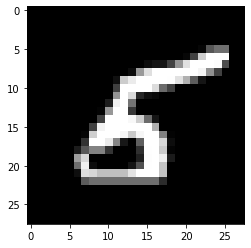

In [9]:
show_image(x_train) # rerun to reselect images

In [10]:
train_mean, train_std = x_train.mean(), x_train.std()
test_near_zero(x_train.mean())
test_near_zero(1 - x_train.std())